# 초기 세팅

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

In [ ]:
!pip install torchsummary
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


- 현재 GPU 설정

In [ ]:
# colab의 runtime-type을 GPU로 설정해서, True가 나오도록 한다.

torch.cuda.is_available()

True

In [ ]:
# gpu('cuda')가 사용가능하면, gpu를 이용하도록 설정

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
device

device(type='cuda')

# CIFAR10 분류 모델
* R/G/B(3) 이미지 데이터 분류
* 32x32 pixel

## 전처리 설정

In [ ]:
# transform 정의

CIFAR_transform = transforms.Compose([transforms.ToTensor(), # tensor로 펴준다.
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # r,g,b 데이터임으로, 3개의 인자값 전달

## 데이터 로드 및 확인

In [ ]:
# datasets

trainset = torchvision.datasets.CIFAR10(root='/content',
                                 train=True, download=True,
                                 transform=CIFAR_transform)

testset = torchvision.datasets.CIFAR10(root='/content',
                                 train=False, download=True,
                                 transform=CIFAR_transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# DataLoader

# batch-size = 4

train_loader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

test_loader = DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

In [ ]:
# 숫자 label에 해당되는 값

class_list = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

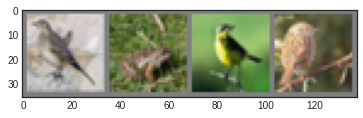

bird	 frog	 bird	 bird	


In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('{}\t'.format(class_list[labels[j]]) for j in range(4)))

## 모델 생성

* input size = 4 * 3 * 32 * 32
* output size = 4 * 10
* 모델 조건
> * convolution-layer : 2개 이상 사용
> * maxpooling-layer : 1개 이상 사용
> * fc-layer : 2개 이상 사용
> * activation-function 으로 'relu' 사용

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module): 
    def __init__(self):
        super(Net, self).__init__()
        #out_channel 증가
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)
        #conv layer도 한 개 추가
        self.conv3 = nn.Conv2d(32, 64, 5)

        self.pool = nn.MaxPool2d(2, 2, 1)

        self.fc1 = nn.Linear(64 * 2 * 2, 192)
        #Full-connection layer도 추가
        self.fc2 = nn.Linear(192, 128)
        self.fc3 = nn.Linear(128, 84)
        self.fc4 = nn.Linear(84, 10)
       

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

net = Net()
print(net)


Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=192, bias=True)
  (fc2): Linear(in_features=192, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=84, bias=True)
  (fc4): Linear(in_features=84, out_features=10, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
)


In [ ]:
myNet = Net().to(device) # gpu에 모델 저장
myNet

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=192, bias=True)
  (fc2): Linear(in_features=192, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=84, bias=True)
  (fc4): Linear(in_features=84, out_features=10, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
)

In [ ]:
# input; (4 * 3 * 32 * 32)

input = images.to(device)
input.size()

torch.Size([4, 3, 32, 32])

In [ ]:
# output; (4 * 10)

output = myNet.forward(input)
output.size()

torch.Size([4, 10])

In [ ]:
# 모델 구조 확인

summary(myNet, input_size=(3,32,32), batch_size=4)
# RGB 데이터일 때는 3
# 흑백 데이터일 때는 1
# cnn1에서는 batchsize = 128 or 64
#ex) summary(model,(1,28,28),batch_size=10)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [4, 16, 28, 28]           1,216
         MaxPool2d-2            [4, 16, 15, 15]               0
            Conv2d-3            [4, 32, 11, 11]          12,832
         MaxPool2d-4              [4, 32, 6, 6]               0
            Conv2d-5              [4, 64, 2, 2]          51,264
         MaxPool2d-6              [4, 64, 2, 2]               0
            Linear-7                   [4, 192]          49,344
            Linear-8                   [4, 128]          24,704
            Linear-9                    [4, 84]          10,836
          Dropout-10                    [4, 84]               0
           Linear-11                    [4, 10]             850
Total params: 151,046
Trainable params: 151,046
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/

## 손실함수와 옵티마이저

In [ ]:
criterion = nn.CrossEntropyLoss() # 다중분류; CrossEntropyLoss
optimizer = optim.SGD(myNet.parameters(), lr=0.001, momentum=0.9) # SGD; lr=0.001 & momentum=0.9

## 모델 학습

In [ ]:
# epochs = 1

for epoch in range(10):
    running_loss = 0.0

    for i, data in enumerate(train_loader, start= 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()                            # 가중치 초기화

        outputs = myNet(inputs)                          # y_pred
        loss = criterion(outputs, labels)                           # 손실함수를 이용해서 loss계산
        loss.backward()                           # back-propagation
        optimizer.step()                          # 가중치 업데이트

        running_loss += loss.item()
        if i % 2000 == 1999:
            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Batch: 2000, Loss: 2.3033900640010834
Epoch: 1, Batch: 4000, Loss: 2.3008269551992417
Epoch: 1, Batch: 6000, Loss: 2.180225087463856
Epoch: 1, Batch: 8000, Loss: 1.9521491405367852
Epoch: 1, Batch: 10000, Loss: 1.808092667132616
Epoch: 1, Batch: 12000, Loss: 1.6915791239738465
Epoch: 2, Batch: 2000, Loss: 1.5930392451584339
Epoch: 2, Batch: 4000, Loss: 1.5455320280641318
Epoch: 2, Batch: 6000, Loss: 1.4724792526066304
Epoch: 2, Batch: 8000, Loss: 1.4377627098038792
Epoch: 2, Batch: 10000, Loss: 1.393411886356771
Epoch: 2, Batch: 12000, Loss: 1.368343451883644
Epoch: 3, Batch: 2000, Loss: 1.317733806375414
Epoch: 3, Batch: 4000, Loss: 1.2963104477487504
Epoch: 3, Batch: 6000, Loss: 1.270912745937705
Epoch: 3, Batch: 8000, Loss: 1.2368130258508025
Epoch: 3, Batch: 10000, Loss: 1.2031789267975836
Epoch: 3, Batch: 12000, Loss: 1.196654257711023
Epoch: 4, Batch: 2000, Loss: 1.1225651656333357
Epoch: 4, Batch: 4000, Loss: 1.1122068539783359
Epoch: 4, Batch: 6000, Loss: 1.1101699804

## 모델의 저장 및 로드

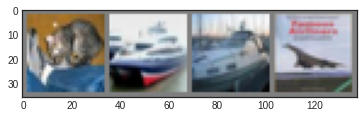

	cat 	ship 	ship 	plane


In [ ]:
# 잘 학습된 모델인지 간단히 한 batch에 대해서 확인

dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(class_list[labels[j]]) for j in range(4))) # batch-size = 4

In [ ]:
# 저장

PATH = './cifar_net.pth'
torch.save(myNet.state_dict(), PATH)

In [ ]:
# 불러오기

Loaded_Net = Net().to(device)
Loaded_Net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 테스트
* 조건
> 전체 accuracy가 70% 이상이어야한다.<br>
> 각각의 class에 대한 accuracy는 60% 이상이어야한다.

In [ ]:
# 전체 accuracy 확인; 70% 이상 성능값

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)                                              # model객체도 gpu에 저장했음으로, 사용되는 데이터도 gpu에 저장한다.; to(device) 사용
        outputs = Loaded_Net(images)                                             # y_pred
        _, predicted = torch.max(outputs.data, axis=1)  # 확률이 가장 큰 것의 label을 최종 예측값으로 선택
        total += labels.size(0) # 전체 갯수
        correct += (predicted == labels).sum().item()   # 맞춘 갯수
    
    print(100 * correct / total)

69.48


- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [ ]:
 #각각의 class에 대한 accuracy 확인; 각각의 class에 대한 60% 이상 성능값

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = Loaded_Net(images)
        _, predicted = torch.max(outputs.data, axis=1)
        c = (predicted == labels).squeeze()
        for i in range(4): # 각각의 batch(batch-size : 4) 마다 계싼
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print("Accuracy of {}: {}%".format(class_list[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 75.7%
Accuracy of car: 83.7%
Accuracy of bird: 55.7%
Accuracy of cat: 43.4%
Accuracy of deer: 73.2%
Accuracy of dog: 46.8%
Accuracy of frog: 80.0%
Accuracy of horse: 67.7%
Accuracy of ship: 90.0%
Accuracy of truck: 76.6%
